In [1]:
import numpy as np
import os
import cv2
import matplotlib
import matplotlib.pyplot as plt

from matplotlib.font_manager import fontManager
#for i in sorted(fontManager.get_font_names()):
#    print(i)
matplotlib.rc('font', family='Microsoft JhengHei')


In [2]:
def plot__BGR(h, w, num, image, title):
    plt.subplot(h, w, num)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis("off")

def plot_gray(h, w, num, image, title):
    plt.subplot(h, w, num)
    plt.imshow(image, cmap = 'gray', vmin=0, vmax=1)
    plt.title(title)
    plt.axis("off")

In [3]:
def dark_channel(image) : 
    # 三通道使用
    H, W, _ = image.shape
    patch_size = 15
    pad_size = patch_size // 2
    #創建 H*W 全零矩陣
    dc = np.zeros((H, W), dtype=np.float32)
    #填充邊界
    #用無限大的值填充的用意是取local min才不會影響到取值
    imJ = np.pad(image ,((pad_size, pad_size), (pad_size, pad_size), (0, 0)), mode='constant', constant_values=np.inf)   
    #計算暗通道
    for j in range(H):
        for i in range(W):
            #遍例3通道, 所有patch為15
            patch = imJ[j:(j+patch_size), i:(i+patch_size),:]
            #將patch中抓到的local min存到dc(j, i)裡
            dc[j, i] = np.min(patch)
            
    return dc


def light_channel(image) : 
    # 三通道使用
    H, W, _ = image.shape
    patch_size = 15
    pad_size = patch_size // 2
    #創建 H*W 全零矩陣
    lc = np.zeros((H, W), dtype=np.float32)
    #填充邊界
    #用負無限大的值填充的用意是取local max才不會影響到取值
    imJ = np.pad(image ,((pad_size, pad_size), (pad_size, pad_size), (0, 0)), mode='constant', constant_values=-np.inf)   
    #計算光通道
    for j in range(H):
        for i in range(W):
            #遍例3通道, 所有patch為15
            patch = imJ[j:(j+patch_size), i:(i+patch_size),:]
            #將patch中抓到的local max存到lc(j, i)裡
            lc[j, i] = np.max(patch)
            
    return lc

In [4]:
def local_maximum(image):
    # 單通道使用
    H, W = image.shape
    patch_size = 15
    pad_size = patch_size // 2
    # 創建 H*W 全零矩陣
    local_max = np.zeros((H, W), dtype=np.float32)
    # 填充邊界
    # 用無限大的值填充的用意是取local max才不會影響到取值
    imJ = np.pad(image ,((pad_size, pad_size), (pad_size, pad_size)), mode='constant', constant_values=-np.inf)
    # 計算local max
    for j in range(H):
        for i in range(W):
            patch = imJ[j:(j+patch_size), i:(i+patch_size)]
            local_max[j, i] = np.max(patch)
            
    return local_max


def local_minimum(image):
    # 單通道使用
    H, W = image.shape
    patch_size = 15
    pad_size = patch_size // 2
    # 創建 H*W 全零矩陣
    local_min = np.zeros((H, W), dtype=np.float32)
    # 填充邊界
    # 用負無限大的值填充的用意是取local min才不會影響到取值
    imJ = np.pad(image ,((pad_size, pad_size), (pad_size, pad_size)), mode='constant', constant_values=np.inf)
    # 計算local max
    for j in range(H):
        for i in range(W):
            patch = imJ[j:(j+patch_size), i:(i+patch_size)]
            local_min[j, i] = np.min(patch)
            
    return local_min

In [5]:
def atmospheric_light(image, dark_channel):
	#在暗通道中找最亮的像素，並在原彩圖中找到對應的位置，來計算大氣光的顏色

	H, W, _ = image.shape
	imsize = H * W													#計算圖像總像素數量
	numpx = np.floor(imsize / 1000).astype(int)						#計算要選擇的像素數量，選前0.1%，並向下取整
	dark_channel_Vec = dark_channel.ravel()							#將dark_channel展平成 imsize *1 的列向量
	ImVec = image.reshape(imsize, 3)								#將原始影像image展平成 imsize * 3 的矩陣
	indices = np.argsort(dark_channel_Vec)							#對暗通道進行升序排序，indices=索引值
	indices = indices[-numpx:]										#選擇排序後最亮的0.1%，計算從哪裡開始提取索引的起點，並到end
	atmSum = np.zeros(3, dtype=np.float32)							#計算大氣光的顏色，創建 1 * 3 全0矩陣，用來儲存最亮像素的顏色值累加和

	#遍例所有選中的像素
	for ind in range(numpx):
		atmSum += ImVec[indices[ind]]								#將每個選中像素的RGB顏色值累加到atmSum

	A = atmSum / numpx												#將atmSum取平均，即為大氣光的顏色

	return A

亮、暗通道 設計A(x)，改進後的DCP

In [6]:
name = 'cones'

t min : 0.04588276 max : 0.79529834


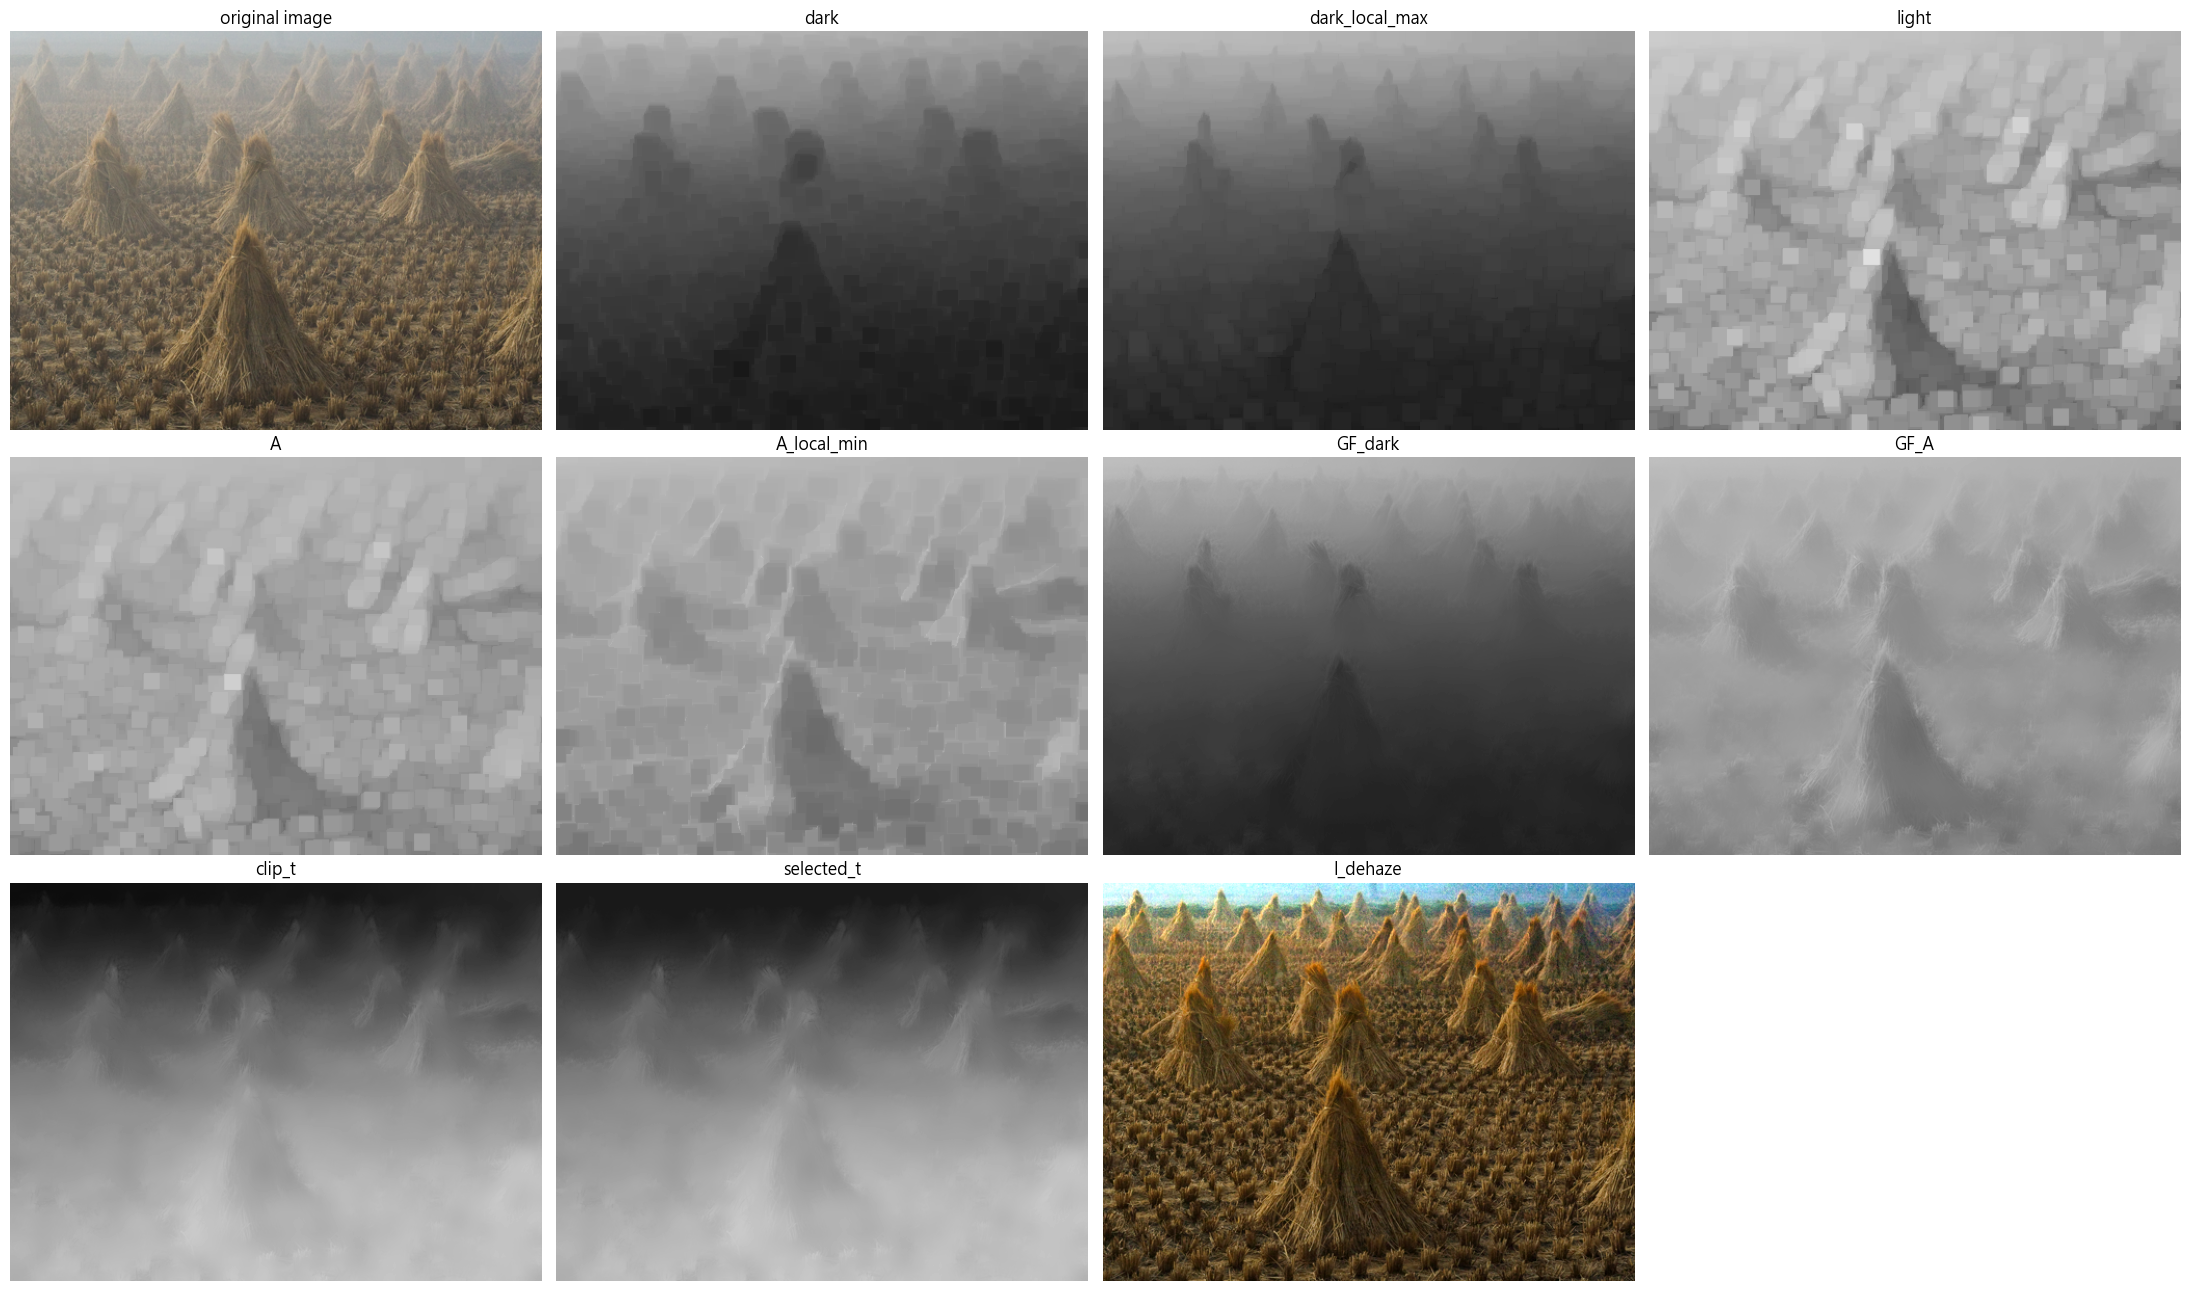

True

In [7]:
image = cv2.imread(f"{name}.png").astype(np.float32)/255.0
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
H, W, C = image.shape

dark = dark_channel(image)
light = light_channel(image)

A0 = atmospheric_light(image, dark)
A0_mean = np.mean(A0)
A = 0.7*light + 0.25*A0_mean



radius = round(np.minimum(H, W) / 50)         # https://kaiminghe.github.io/publications/thesis.pdf   p.95
# radius = 60
eps = 1e-4
dark_local_max = local_maximum(dark)
A_local_min = local_minimum(A)
GF_dark = cv2.ximgproc.guidedFilter(guide=image_gray, src=dark_local_max, radius=radius, eps=eps)
GF_A = cv2.ximgproc.guidedFilter(guide=image_gray, src=A_local_min, radius=radius, eps=eps)
t = 1 - 0.95 * (GF_dark/GF_A)
clip_t = np.clip(t, 0, 1)
print("t min :", np.min(t), "max :", np.max(t))
t0 = 0.1
selected_t = cv2.max(clip_t, t0)


I_dehaze = np.zeros_like(image)
for i in range(C):
    I_dehaze[:, :, i] = (image[:, :, i] - GF_A)/selected_t + GF_A
I_dehaze = np.clip(I_dehaze, 0, 1)

plt.figure(figsize=(22, 13))
h, w = 3, 4
plot__BGR(h, w, 1, image, "original image")
plot_gray(h, w, 2, dark, "dark")
plot_gray(h, w, 3, dark_local_max, "dark_local_max")
plot_gray(h, w, 4, light, "light")
plot_gray(h, w, 5, A, "A")
plot_gray(h, w, 6, A_local_min, "A_local_min")
plot_gray(h, w, 7, GF_dark, "GF_dark")
plot_gray(h, w, 8, GF_A, "GF_A")
plot_gray(h, w, 9, clip_t, "clip_t")
plot_gray(h, w, 10, selected_t, "selected_t")
plot__BGR(h, w, 11, I_dehaze, "I_dehaze")

plt.tight_layout()
plt.show()


cv2.imwrite(f"light result ({name}).png", (I_dehaze*255).astype(np.uint8))

原始DCP

In [8]:
def main_dehaze(name):

    image = (cv2.imread(f"{name}.png").astype(np.float32))/255

    H, W, C = image.shape
    I_dark = dark_channel(image)
    A = atmospheric_light(image, I_dark)
    image_A = np.zeros_like(image)
    for i in range(C):
        image_A[:, :, i] = image[:, :, i]/A[i]
    image_A_dark = dark_channel(image_A)
    image_A_dark_local_max = local_maximum(image_A_dark)
    t = 1 - 0.95 * image_A_dark_local_max

    radius = round(np.minimum(H, W) / 50)         # https://kaiminghe.github.io/publications/thesis.pdf   p.95
    # radius = 60
    eps = 1e-4
    I_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    GF_t = cv2.ximgproc.guidedFilter(guide=I_gray, src=t, radius=radius, eps=eps)

    t0 = 0.1
    I_dehaze = np.zeros_like(image)
    for i in range(C):
        I_dehaze[:, :, i] = (image[:, :, i] - A[i])/cv2.max(GF_t, t0) + A[i]
    I_dehaze = np.clip(I_dehaze, 0, 1)

    return image, I_dark, image_A, image_A_dark, image_A_dark_local_max, t, GF_t, I_dehaze

In [9]:
image, I_dark, image_A, image_A_dark, image_A_dark_local_max, t, GF_t, DCP_I_dehaze = main_dehaze(f"{name}")

cv2.imwrite(f"DCP result ({name}).png", (DCP_I_dehaze*255).astype(np.uint8))

True

比較原本的DCP和後來改進的

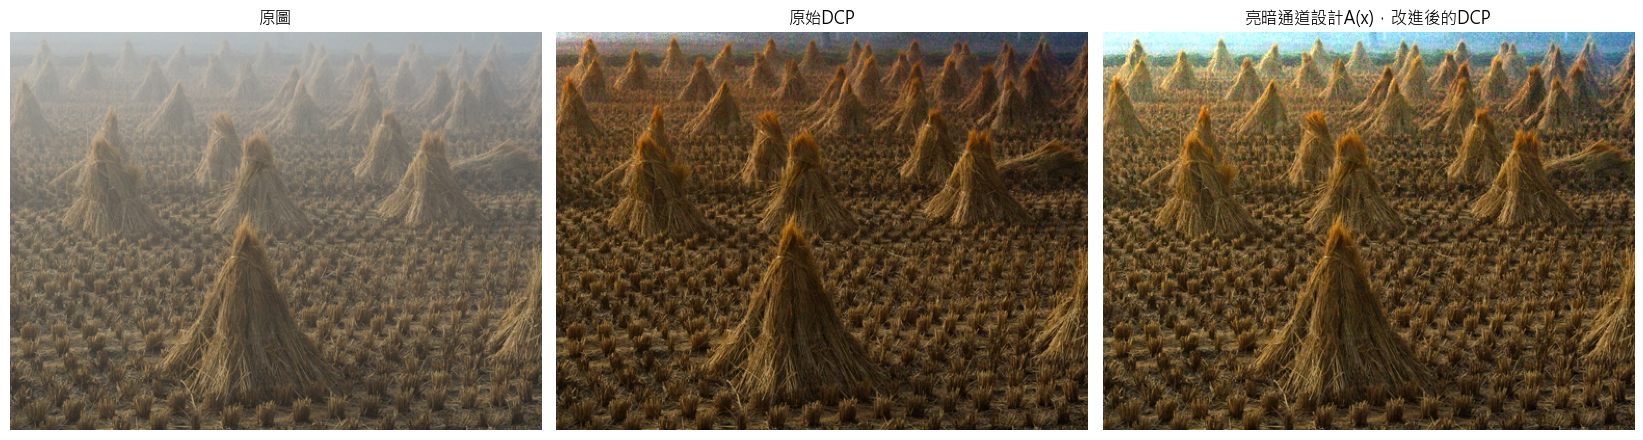

In [10]:
plt.figure(figsize=(22, 13))
h, w = 1, 4
plot__BGR(h, w, 1, image, "原圖")
plot__BGR(h, w, 2, DCP_I_dehaze, "原始DCP")
plot__BGR(h, w, 3, I_dehaze, "亮暗通道設計A(x)，改進後的DCP")

plt.tight_layout()
plt.savefig(f'比較圖 ({name}).png', dpi=600, bbox_inches='tight')
plt.show()